## Data 620 Final Project
#### By Anjal Hussan, Zhouxin Shi, Chunjie Nan

## [Video Presentation](https://www.youtube.com/watch?v=FYsxROeMzjc)
## Abstract

Using primarily the libraries `nltk`, `pandas`, `networkx`, and `matplotlib`, two sets of data were observed. One set was the Marvel Wikia Data, a comma-seperated values file provided by the company 538 on their Github account. This set of data only had its names and alignments (Good, Neutral, Bad) utilized. The other set of data was compiled by going over two texts, The Elder Edda and The Younger Eddas. Using sentiment analysis and text analysis, alignments were assigned to each of a set of twenty one mythological beings within the text that were either monstrous, giants, or divine in nature. The Marvel data's alignments were then compared to the text data's alignments, which concluded that the analysis performed of the text was more accurate than Marvel's assignments of alignments, though very similar overall. The most accurate results came from the normalized average sentiment scores. Marvel differed mainly in the alignments of Sigyn, Sleipnir, Tyr, and Utgard-Loki. Based on further analysis, it was determined that beings of a given alignment were more likely to interact with those of the same alignment as them. Those who were least likely to interact with other alignments were those of the Good alignment.

## Objective

To analyze the Elder and Younger Eddas' most prolific and well-known beings, their relationships, their alignments and how those alignments compare to their Marvel counterparts.

## Data Setup

In [42]:
import requests
import nltk
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import pandas as pd
import networkx as nx
import networkx.algorithms.bipartite as bipartite
import matplotlib.pyplot as plt
import numpy as np
import nltk
nltk.download('vader_lexicon')
%matplotlib inline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jshi3\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In order to bring in the text file containing the Elder Edda and the Younger Edda, the `requests` is positively vital. The `nltk` library's ability to analyze sentiment is next and also of utmost importance - the whole project rests on this library's SentimentIntensityAnalyzer tool. After that is `re`, which is the library containing functions for working with regular expressions which were used for cleaning the texts. Next is another star, `pandas`, who allows for easier working with data and for bringing the Marvel Wikia CSV straight into a data frame. Then there's `networkx`, which allows for network mapping which will help identify relationships between the beings in the Eddas, and `matplotlib` which offers bar graphs and scatter plots. Finally, there is `numpy`, which gives the ability to do certain equations more easily.

### Marvel Wikia names and alignment

The [Marvel Wikia](http://marvel.wikia.com/wiki/Marvel_Database) offers a plethora of information. Our only interest was in Norse pantheon's character from the Earth-616 universe. To do this, information was originally stripped from the Wikia by 538 and posted onto [their Github](https://github.com/fivethirtyeight/data/blob/master/comic-characters/) in CSV format.

In [43]:
wikia_url = "https://raw.githubusercontent.com/gabartomeo/data620-cunysps/master/Final%20Project/Data/marvel-wikia-data.csv"
wikia_df = pd.read_csv(wikia_url)[["name", "ALIGN"]]
wikia_df.at[9084, "ALIGN"] = "Neutral Characters"
wikia_df = wikia_df.dropna()
wikia_df = wikia_df[wikia_df["name"].apply(lambda name: True if re.match("^(Thor|Loki|Odin|Sif|Sigyn|Frigga?|Freya|Freyr?|Heimdall|Utgard-Loki|Fenris|Idunn|Tyr|Jormungand|Hela|Hati|Skoll|Balde?r|Bragi|Angerboda|Sleipnir) ", name) else False)].copy()
wikia_df["shortened"] = wikia_df["name"].apply(lambda name: re.sub(" .*", "", name) if " " in name else name)
wikia_df["ALIGN"] = wikia_df["ALIGN"].apply(lambda malign: malign.replace(" Characters", ""))
wikia_df = wikia_df.drop_duplicates(subset="shortened")
wikia_df = wikia_df.sort_values(by="shortened")[["name", "ALIGN"]].reset_index(drop=True).copy()
wikia_df["name"] = wikia_df["name"].apply(lambda name: re.sub(" \(.*\)", "", name) if "(" in name else name)
wikia_df = wikia_df.rename(index=str, columns={"name": "name, Marvel", "ALIGN": "alignment, Marvel"})

In order to use the CSV file going forward, it had to be brought into Python. To do this, the `pandas` library was used as it has a function, `read_csv()` that makes a CSV - even one from a website - straight into a data frame. Only the columns giving a character's name and alignment were needed for analysis, so all the other columns were dropped. Each character was gone through, looking for the ones based on a set of the Norse deities, monsters, and jotunn - which is the word for giant in Old Norse. In particular, we were looking for, in Marvel character form,

* the Gods: Baldr, Bragi, Freyr, Freyja, Frigg, Heimdall, Hel, Idunn, Loki, Odin, Sif, Sigyn, Thor, and Tyr;
* the jotunn: Angrboda and Utgard-Loki;
* and the monsters: Hati, Skoll, Fenrir, Jormungandr, and Sleipnir

There was minimal editing done to the data itself, outside of dropping the name of the Marvel universe these characters were from and dropping the word "Characters" from their alignment. To account for duplicate names, the first instance of each name was kept only, and the first instance of each name was always a character from the Earth-616 universe. The resulting table can be viewed below.

In [44]:
wikia_df

,"name, Marvel","alignment, Marvel"
0,Angerboda,Neutral
1,Balder Odinson,Good
2,Bragi,Good
3,Fenris Wolf,Bad
4,Frey,Good
5,Freya,Good
6,Frigga,Good
7,Hati,Bad
8,Heimdall,Good
9,Hela,Bad


### Going through the Eddas

The Eddas (both the Elder Edda and the Younger Edda) were [available online](https://www.gutenberg.org/ebooks/14726) via Project Gutenberg. These texts are important for the analyses going forward as they will be used for determining the alignment of various beings which the Norse pantheon in Marvel's universe is based on -- the actual Norse pantheon, the jotunn (the Old Norse word for "giant"), and a variety of monsters for lack of a better term.

In [45]:
text_url = "https://raw.githubusercontent.com/gabartomeo/data620-cunysps/master/Final%20Project/Data/elder%20and%20younger%20eddas%20translated.txt"
raw_text = requests.get(text_url).content.decode('utf-8')
test = re.findall("\n +(.*[^ ]) {2,}\d+", raw_text)
eddas = {}
chapters = [chapter.upper() for chapter in re.findall("\n +(.*[^ ]) {2,}\d+", raw_text)][:-2]
raw_text = re.sub("((\n[A-ZÀÂÄÖÔÉÈËÊÏÎŸÇÙÛÜÆŒ][A-ZÀÂÄÖÔÉÈËÊÏÎŸÇÙÛÜÆŒ \.\'\-]+\.)|(ODIN BEGUILES THE DAUGHTER OF BAUGI))", "NEW CHAPTER\n\\1\n", raw_text)
raw_text = re.sub("_([a-zA-ZäöüàâäôéèëêïîçùûüÿæœÀÂÄÖÔÉÈËÊÏÎŸÇÙÛÜÆŒ]+)\.?_\.?[\r\n]{0,}([\r\n]{1}\d+\. )([\'\"A-Za-z])", "\\2\\1: \\3", raw_text, flags=re.UNICODE)
chapters_split = raw_text.split("NEW CHAPTER")[16:-32]
for i in range(0, len(chapters)):
    eddas[chapters[i]] = re.split("[\r\n]{2}\d+\.", chapters_split[i])[1:]
    for each_verse in range(0, len(eddas[chapters[i]])):
        eddas[chapters[i]][each_verse] = re.sub("[\r\n]+", " ", eddas[chapters[i]][each_verse]).strip()
        eddas[chapters[i]][each_verse] = re.sub("(\[.*\])|( FOOTNOTES:)", "", eddas[chapters[i]][each_verse])

The Eddas both share a single text file and were brought into Python using the `requests` library. From there, `re` was used to identify regular expression patterns and break up the texts into chapters and to change the formatting for some instance of dialogue so it would be more clear in the sentiment analysis who was saying what.

In [46]:
sent_tokens = {}

for chapter in chapters:
    sent_tokens[chapter] = [nltk.sent_tokenize(verse) for verse in eddas[chapter]]
    sent_tokens[chapter] = [sentence for sentences in sent_tokens[chapter] for sentence in sentences]

sent_tokens_list = [sentence for current_list in list(sent_tokens.values()) for sentence in current_list]
elder_sent_tokens_list = [sentence for current_list in list(sent_tokens.values())[:37] for sentence in current_list]
younger_sent_tokens_list = [sentence for current_list in list(sent_tokens.values())[37:] for sentence in current_list]

`nltk` then got to make its debut as it was used for breaking each chapters into sentences, with the Elder Edda and the Younger Edda having their sentences stored separately in case it were to be decided they would be used later. They ultimately were not, but the possibility still existed.

In [47]:
sia = SentimentIntensityAnalyzer()

add_to_lexicon = {
    "devour": "murder", "slay": "kill", "slain": "killed", "devourer": "murderer", "slayer": "murderer", 
    "devoured": "murdered", "swallowed": "murdered", "womanish": "weak", "emasculate": "weaken", 
    "emasculated": "weaken","perish": "die", "lifeless": "dead", "monster": "scary", 
    "monsters": "scary", "monstrous": "scary", "troll": "scary", "demon": "scary", "demons": "scary",
    "perils": "peril", "burst": "broke", "conceal": "hide", "deadly": "dangerous",
    "raving": "crazy", "unequally": "unequal", "dastardly": "cruel", "terror-stricken": "terror",
    "scoffing": "mocking", "false": "lying", "falsehoods": "lies", "vomit": "puke", "vomits": "puke",
    "opprobrius": "criticising", "bane": "burden", "reproachful": "disappointing", "strife": "conflict", 
    "chafe": "irritate", "impure": "imperfect", "pure": "perfect", "holy": "divine",
    "sacred": "divine", "celestial": "divine", "aid": "help", "assist": "help", "assistance": "help",
    "advice": "help", "fain": "gladly", "producing": "creating", "mighty": "strong",
    "distinguish": "popular", "distinguished": "popular", "famous": "popular",
    "famed": "popular", "benignent": "kindly", "propitious": "favorable",
    "assented": "agreed", "wished": "wish", "prophecy": "divination", "gods": "god",
    "defended": "protected", "joyed": "enjoyed", "contented": "satisfied", "amends": "apologize",
    "placable": "gentle", "gifts": "gift", "oath": "promise", "boast": "pride",
    "oaths": "promise", "valor": "courage", "valour": "courage", "salutation": "greeting",
    "salutations": "greetings", "might": "strength", "vigorously": "vigor", "defend": "protect",
    "incredible": "amazing", "tremendous": "great", "consenting": "consent", "renown": "popular"
}

for k,v in add_to_lexicon.items():
    sia.lexicon[k] = sia.lexicon[v]

scores = [sia.polarity_scores(sentence) for sentence in sent_tokens_list]

The Sentiment Intensity Analyzer was assigned to the variable `sia` and a wide variety of words were added to the lexicon to make up for the archaic language of the document. This is due to the fact the base lexicon being utilized is more geared for modern texts and writings such as e-mails, text messages, and Twitter. With its updated lexicon, `sia` was used to assign a polarity score to each and every single sentence present in the Eddas.

In [48]:
gods = ["Odin", "Thor", "Loki", "Frigg", "Freyr", "Freyja", "Bragi", "Tyr", "Sif", "Baldr", "Heimdall", "Sigyn", "Hel", "Idunn"]
giants = ["Utgard-Loki", "Angrboda"]
monsters = ["Fenrir", "Jormungandr", "Hati", "Skoll", "Sleipnir"]

The names of the Gods, jotunn, and monsters that were already grabbed from Marvel were each given their own list for the sake of repetitive use.

In [49]:
def myth_scores(being_name):
    if being_name == "Fenrir":
        list_of_sentences = [sentence if len(re.findall("(Fenri)|(Hr[ôo]dvitnir)", sentence)) > 0 else None for sentence in sent_tokens_list]
    elif being_name == "Loki":
        list_of_sentences = [sentence if len(re.findall("(?:(?:^)|(?:[^-]))Loki", sentence)) > 0 else None for sentence in sent_tokens_list]
    elif being_name == "Freyja":
        list_of_sentences = [sentence if len(re.findall("Frey[ij]?a", sentence)) > 0 else None for sentence in sent_tokens_list]
    elif being_name == "Tyr":
        list_of_sentences = [sentence if len(re.findall("\\bTyr?\\b", sentence)) > 0 else None for sentence in sent_tokens_list]
    elif being_name == "Idunn":
        list_of_sentences = [sentence if len(re.findall("I[td]h?unn?a", sentence)) > 0 else None for sentence in sent_tokens_list]
    elif being_name == "Jormungandr":
        list_of_sentences = [sentence if len(re.findall("((?:Jormungandr?)|(?:Midgard [Ss]erpent))", sentence)) > 0 else None for sentence in sent_tokens_list]
    elif being_name == "Hel":
        list_of_sentences = [sentence if len(re.findall("\\bHela?\\b", sentence)) > 0 else None for sentence in sent_tokens_list]
    elif being_name == "Frigg":
        list_of_sentences = [sentence if len(re.findall("\\bFrigga?\\b", sentence)) > 0 else None for sentence in sent_tokens_list]
    elif being_name == "Freyr":
        list_of_sentences = [sentence if len(re.findall("\\bFreyr?\\b", sentence)) > 0 else None for sentence in sent_tokens_list]
    elif being_name == "Sigyn":
        list_of_sentences = [sentence if len(re.findall("\\b(Sig(?:(?:yn)|(?:una)))\\b", sentence)) > 0 else None for sentence in sent_tokens_list]
    elif  being_name == "Angrboda":
        list_of_sentences = [sentence if len(re.findall("\\bAngu?rbod[ai]\\b", sentence)) > 0 else None for sentence in sent_tokens_list]
    else:
        list_of_sentences = [sentence if len(re.findall("\\b" + being_name + "\\b", sentence)) > 0 else None for sentence in sent_tokens_list]        
    list_of_sentences = list(filter(None, list_of_sentences))
    being_scores = [scores[sent_tokens_list.index(sentence)] for sentence in list_of_sentences]
    return({"sentences": list_of_sentences, "scores": being_scores})

A function was created for assigning sentences and their scores to each being, called `myth_scores()`. This process was done by looking at the name of whatever being was entered into the function and then comparing it against a list of names that had spelling variations in the text. Each spelling variation, if the being were to have one, would be searched for in the list using regular expressions and a list of sentences were returned with that being's name. Those list of sentences also had their corresponding score stored, and the function returned a dictionary bearing the list of sentences and the scores for each sentence.

In [50]:
gods_df = {}
giants_df = {}
monsters_df = {}

for god in gods:
    gods_df[god] = myth_scores(god)

for giant in giants:
    giants_df[giant] = myth_scores(giant)
    
for monster in monsters:
    monsters_df[monster] = myth_scores(monster)

The function `myth_scores()` was used on each God, jotunn, and monster and the sentences and their scores for each being were stored.

In [51]:
raw_myth_df = {
    "name": [],
    "status": [],
    "sentence": [],
    "positive": [],
    "neutral": [],
    "negative": [],
    "pos-neg": []
}

for each in [gods, giants, monsters]:
    each_df = [gods_df, giants_df, monsters_df][[gods, giants,monsters].index(each)]
    status = ["God", "Jotunn", "Monster"][[gods, giants,monsters].index(each)]
    for being in each:
        raw_myth_df["name"] += [being]*len(each_df[being]["scores"])
        raw_myth_df["status"] += [status]*len(each_df[being]["scores"])
        raw_myth_df["sentence"] += each_df[being]["sentences"]
        for score in each_df[being]["scores"]:
            raw_myth_df["positive"] += [score["pos"]]
            raw_myth_df["neutral"] += [score["neu"]]
            raw_myth_df["negative"] += [score["neg"]]
            raw_myth_df["pos-neg"] += [score["pos"]-score["neg"]]


The three dictionaries created - one for each category of being - were then combined into a single dictionary bearing seven keys: the name of each being; their status - God, jotunn, monster; each sentence for them; the positive sentimentality score, the neutral sentimentality score, the negative sentimentality score; and the value of subtracting the negative sentimentality score from the positive one.

This single dictionary was then made into a data frame, `myth_df`, with the z-score for each sentimentality score for each sentence added on. A sample of this data frame is observable below.

In [52]:
myth_df = pd.DataFrame(raw_myth_df).drop_duplicates()

for column in list(myth_df.columns)[-4:-1]:
    column_z = "z " + column
    myth_df[column_z] = (myth_df[column] - myth_df[column].mean())/myth_df[column].std(ddof=0)

myth_df.sample(n=10)

,name,status,sentence,positive,neutral,negative,pos-neg,z positive,z neutral,z negative
653,Angrboda,Jotunn,"""Loki,"" continued Har, ""has likewise had three...",0.000,1.000,0.000,0.000,-0.786204,1.118557,-0.660113
6,Odin,God,Then comes the mighty son of Hlôdyn: (Odin's s...,0.095,0.575,0.330,-0.235,0.080026,-1.875478,2.341632
669,Fenrir,Monster,"Fenrir then breaks loose, and the sea rushes o...",0.100,0.819,0.082,0.018,0.125617,-0.156550,0.085775
251,Thor,God,"But tell me, did Thor ever avenge this affront?""",0.000,1.000,0.000,0.000,-0.786204,1.118557,-0.660113
229,Thor,God,"""Thor looked at the horn, which seemed of no e...",0.029,0.948,0.022,0.007,-0.521776,0.752228,-0.459997
108,Odin,God,"The wolf swallows Odin, but at that instant Vi...",0.106,0.766,0.127,-0.021,0.180326,-0.529924,0.495104
332,Loki,God,"After this Loki, in the likeness of a salmon, ...",0.000,1.000,0.000,0.000,-0.786204,1.118557,-0.660113
529,Tyr,God,"He is the most fearful monster of all, and att...",0.000,0.452,0.548,-0.548,-0.786204,-2.741987,4.324604
618,Hel,God,"""Evil are the deeds of Loki truly,"" said Gangl...",0.000,0.730,0.270,-0.270,-0.786204,-0.783536,1.795861
303,Loki,God,"Odin: Thou art raving, Loki!",0.000,0.598,0.402,-0.402,-0.786204,-1.713448,2.996559


## Data Analysis

After gathering the scores of all the sentences of the beings we're interested in and their mentions in the Eddas, it was time to work on getting things to a point where analysis could really be performed, and where what is in the text could be compared to what Marvel presented - how far did Marvel get from their source material for the Thor comics and movies?

In [53]:
alignment_stats = pd.DataFrame({"name": gods+giants+monsters, 
                                "status": ["God"]*len(gods) + ["Jotunn"]*len(giants) + ["Monster"]*len(monsters)})
alignment_stats["avg positive"] = [np.mean(myth_df[myth_df["name"]==name]["positive"]) for name in alignment_stats["name"]]
alignment_stats["avg neutral"] = [np.mean(myth_df[myth_df["name"]==name]["neutral"]) for name in alignment_stats["name"]]
alignment_stats["avg negative"] = [np.mean(myth_df[myth_df["name"]==name]["negative"]) for name in alignment_stats["name"]]
alignment_stats["avg pos-neg"] = [np.mean(myth_df[myth_df["name"]==name]["pos-neg"]) for name in alignment_stats["name"]]
alignment_stats["avg z pos"] = [np.mean(myth_df[myth_df["name"]==name]["z positive"]) for name in alignment_stats["name"]]
alignment_stats["avg z neu"] = [np.mean(myth_df[myth_df["name"]==name]["z neutral"]) for name in alignment_stats["name"]]
alignment_stats["avg z neg"] = [np.mean(myth_df[myth_df["name"]==name]["z negative"]) for name in alignment_stats["name"]]
alignment_stats["norm avg pos"] = ((alignment_stats["avg positive"] - alignment_stats["avg positive"].mean())/alignment_stats["avg positive"].std(ddof=0)).tolist()
alignment_stats["norm avg neu"] = ((alignment_stats["avg neutral"] - alignment_stats["avg neutral"].mean())/alignment_stats["avg neutral"].std(ddof=0)).tolist()
alignment_stats["norm avg neg"] = ((alignment_stats["avg negative"] - alignment_stats["avg negative"].mean())/alignment_stats["avg negative"].std(ddof=0)).tolist()
alignment_stats = alignment_stats.sort_values(by="name").reset_index(drop=True)

A new data frame was made, so-named `alignment_stats`, that gathered the information from the `myth_df` data frame and sorted it out into its final numerical values.

For each being's sentences, the average was gathered for the positive, neutral, and negative sentiment scores. The previously made positive sentimentality score minus negative sentimentality score was also averaged. The average of each of the z-scores was also calculated, as was the normalized values for the aforementioned average sentimentality scores.

In [54]:
alignment_stats

,name,status,avg positive,avg neutral,avg negative,avg pos-neg,avg z pos,avg z neu,avg z neg,norm avg pos,norm avg neu,norm avg neg
0,Angrboda,Jotunn,0.000000,0.856000,0.144000,-0.144000,-0.786204,0.104107,0.649740,-1.862611,0.527863,1.811535
1,Baldr,God,0.113714,0.791714,0.094571,0.019143,0.250667,-0.348772,0.200128,0.555821,-0.807234,0.369569
2,Bragi,God,0.134160,0.821960,0.043880,0.090280,0.437095,-0.135697,-0.260972,0.990652,-0.179086,-1.109237
3,Fenrir,Monster,0.107950,0.788550,0.103700,0.004250,0.198107,-0.371064,0.283163,0.433228,-0.872951,0.635875
4,Freyja,God,0.092000,0.810429,0.097571,-0.005571,0.052671,-0.216934,0.227416,0.094009,-0.418573,0.457088
5,Freyr,God,0.114917,0.820639,0.064444,0.050472,0.261630,-0.145004,-0.073913,0.581392,-0.206523,-0.509317
6,Frigg,God,0.132484,0.835677,0.031935,0.100548,0.421812,-0.039061,-0.369621,0.955005,0.105800,-1.457691
7,Hati,Monster,0.039333,0.813000,0.147833,-0.108500,-0.427554,-0.198818,0.684608,-1.026085,-0.365169,1.923364
8,Heimdall,God,0.148000,0.772250,0.079750,0.068250,0.563291,-0.485894,0.065309,1.284996,-1.211472,-0.062812
9,Hel,God,0.056569,0.862000,0.081431,-0.024863,-0.270399,0.146376,0.080603,-0.659531,0.652472,-0.013762


This chart above gives for each of the beings listed their average positive, neutral, and negative rating based on the sentiment analysis that was previously performed. It also gives a polarized score, `avg pos-neg`, that was created by multiplying the average positive score by 1, the average neutral score by 0, and the average negative score by -1, and then adding them up for each row as a way to sort each being into a Good or Bad alignment. While novel, it only sections beings into two categories, Good or Bad, but never Neutral.

From there, there was the averages of the positive, neutral, and negative z-scores for each being. These scores indicate correlation, and so a being with an average positive z-score that is less than zero is less likely to be of the Good alignment; in short, a positive number in one of the average z-score categories indicates a corrolation with either a Good, Neutral, or Bad alignment. These z-scores are visualized below, with values greater than 0 indicating a positive corrolation, and less than 0 indicating a negative corrolation.

Lastly, there were the normalized average sentiment scores. These were the z-scores of each of the averages for each being, which hold to the same rules as just explained: negative numbers, negative correlation; positive numbers, positive corrolation.

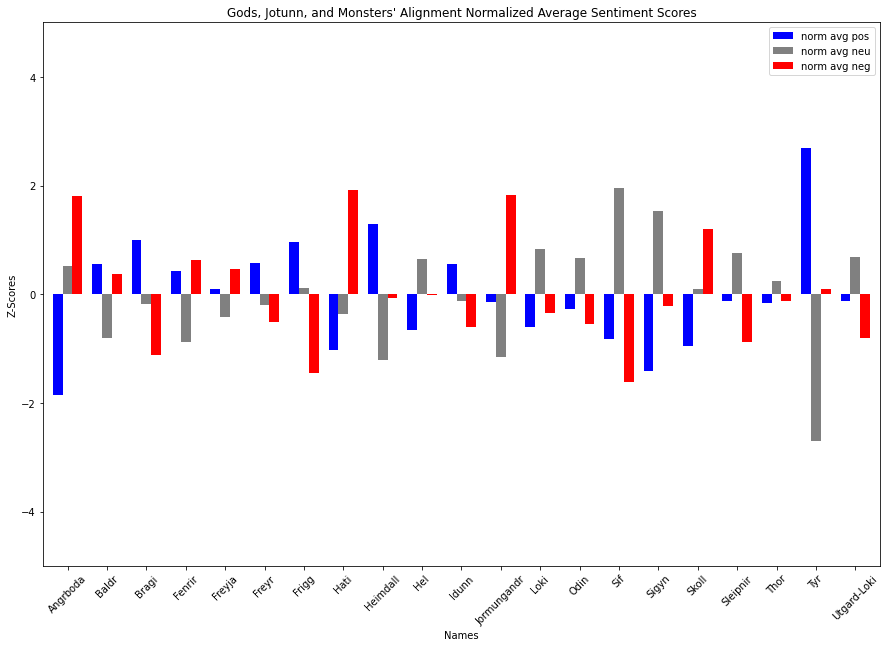

In [55]:
alignment_stats_plot = alignment_stats.plot.bar(x="name", y=["norm avg pos", "norm avg neu", "norm avg neg"],
                         title="Gods, Jotunn, and Monsters' Alignment Normalized Average Sentiment Scores",
                         rot=45, figsize=(15,10), width=0.75, color=["b", "gray", "r"])
alignment_stats_plot.set_xlabel("Names")
alignment_stats_plot.set_ylabel("Z-Scores")
alignment_stats_plot.set_ylim((-5, 5))
plt.show()

It is immediately evident that the characters who are least likely to be Neutral are Baldr, Heimdall, Jormundgandr, and Tyr. Their very negative average z-scores for neutrality indicate the greatest likelihood of them being good or bad. Tyr is the most clear example of this, as his high z-score for positivity shows he's likely to be of a Good alignment.

For a truly polarizing beings, we have Hati and Skoll, both labeled as monsters for the sake of this project. They have negative average z-scores for positivity, and high average z-scores for negativity. This makes perfect sense, given that in the myths they are the wolves that chase the sun and moon, and will devour them at Ragnarok, which is basically an apocalyptic event that would see most all the Gods, jotunn, monsters, and humanity dead. We also have the jotunn Angrboda, with a positive negative z-score average and a negative positive z-score average, who is the grandmother of Hati and Skoll, and the mother of Fenrir and Jormungandr.

Using this information, we can predict the alignment of each being based on the analysis performed thusfar.

### Alignments based on data analysis

In [56]:
alignments = alignment_stats[["name", "status"]].copy()
alignments["tmp"] = list(range(len(alignments)))
a = wikia_df.iloc[4].copy()
b = wikia_df.iloc[5].copy()
wikia_df.iloc[4] = b
wikia_df.iloc[5] = a
wikia_df["tmp"] = list(range(len(wikia_df)))
alignments = alignments.merge(wikia_df, on="tmp")
wikia_df = wikia_df.drop("tmp", axis=1)
alignments = alignments.drop("tmp", axis=1)
alignments["alignment, avg"] = ["Good" if score > 0 else "Bad" for score in alignment_stats["avg pos-neg"].tolist()]
alignments["alignment, z"] = alignment_stats[["avg z pos", "avg z neu", "avg z neg"]].idxmax(axis=1).replace(
    {"avg z pos": "Good", "avg z neu": "Neutral", "avg z neg": "Bad"})
alignments["alignment, norm"] = alignment_stats[["norm avg pos", "norm avg neu", "norm avg neg"]].idxmax(axis=1).replace(
    {"norm avg pos": "Good", "norm avg neu": "Neutral", "norm avg neg": "Bad"})

To do this, a temporary column was created for both the data frame made using the Wikia's information, and the data frame made for the alignment statistics. These two data frames were then combined on this temporary column, which was removed thereafter. There were three alignments to be considered: the alignments based on the average scores, the alignments based on average z-scores, and the alignments based on the normalized average sentiment scores. The alignments based on average score did not offer the Neutral option as previously mentioned, while the average z-scores and the normalized average sentiment scores looked at the largest value greater than 0 to determine whether or not a character was correlated with a certain alignment.

In [57]:
alignments

,name,status,"name, Marvel","alignment, Marvel","alignment, avg","alignment, z","alignment, norm"
0,Angrboda,Jotunn,Angerboda,Neutral,Bad,Bad,Bad
1,Baldr,God,Balder Odinson,Good,Good,Good,Good
2,Bragi,God,Bragi,Good,Good,Good,Good
3,Fenrir,Monster,Fenris Wolf,Bad,Good,Bad,Bad
4,Freyja,God,Freya,Good,Bad,Bad,Bad
5,Freyr,God,Frey,Good,Good,Good,Good
6,Frigg,God,Frigga,Good,Good,Good,Good
7,Hati,Monster,Hati,Bad,Bad,Bad,Bad
8,Heimdall,God,Heimdall,Good,Good,Good,Good
9,Hel,God,Hela,Bad,Bad,Neutral,Neutral


These four alignments provided compare fairly well with the actual alignments from reading the Elder and Younger Eddas, though some better than others. Looking at the three alignments on their own, it can be noted that they are in agreement for the most part. Where they differ are where some interesting stories lie.

To start with, Fenrir. Somehow the average of the sentimentality scores has him being ever-so-slightly more Good than Bad, although most all references to him are negative - though it is important to recall this scoring in particular lacks a Neutral option.

Then there's Freyja. In the Earth-616 Marvel universe, she is regarded as a Good character, but from the data, it's implied she's Bad. This largely has to do with other beings in the Eddas mentioning her in a negative light. For example, the line

> Hyndla: False are thou, Freyia!

Here, there's a Norse shaman, called a völva, calling Freyja false. Pretty negative statement to be made about the Goddess - it doesn't have a positive sentiment score, and its negative sentiment score is 0.480. Ouch. The next two lines have a positive sentiment score of 0 and a negative sentiment score greater than 0.45 as well. Her most positive sentence is her talking about riding her horse, and its positivity score is only 0.375. Freyja's sentiment score suffers from negative discourse about and by her, although she herself is actually considered a Good being.

The next difference is with the Goddess Hel. She's a Goddess of the Underworld, where souls who did not die valiantly go upon passing. It's not for the souls of evil, it's not filled with demons or anything of the such. It's just cold and lacking in parties. Not particularly evil, but the average sentiment alignment lacks the ability to select Neutral, and Marvel needed an easy villain.

After that is Loki. Loki is an interesting one who could have several papers written about him. That aside, the average sentiment alignment lacks the ability to assign Neutral, and Loki does have a whole chapter dedicated to him badmouthing the Gods.

Following Loki is his bloodbrother, Odin. Another victim of the average sentiment alignment that can be accredited for in part by the general Good view of Odin.

Sif is not particular good or bad, one way or another. She does her own thing, and the average sentiment alignment could not account for that; her interactions on the whole are positive in the texts. Sigyn, on the other hand, was assigned the whole scale of possibilities. She is often mentioned with Loki, and that makes her more Bad than not through association, but she is more a dutiful wife than anything else, and therefore Neutral.

Sleipnir is, strangely enough, Good in the Marvel Universe. He could be considered Good, as he works for Odin... but Sleipnir is a horse. Granted, a many-legged horse that's the son of Loki, but still a horse. Good horse? Neutral horse? Who is to say?

Another deity with a full spread is Thor. In the comics, he is a Good character - the comics are named Thor for a reason. In the texts, he really is more Neutral, getting into trouble with Loki and going on crazy hijinks with him. The fact he has killed people likely is what tilts his scores more Neutral than Good with the average sentiment analysis.

Tyr... his only excuse is that Marvel needed a character to switch sides from Good to Bad, a fallen character, and he was picked for this for some reason.

Lastly is the jotunn Utgard-Loki. He was made bad in the comics, but in the Eddas, his worst crimes were throwing a party where he tried to best Thor in a battle of wits with some trickery thrown in. He wasn't particularly Good or particularly Bad. He just was.

With all these explained, it would be good to see how Marvel, the average sentiment scores, the average z-scores, and the normalized average sentiment scores did against each being's commonly accepted alignment.

In [58]:
alignments["accepted"] = [["Neutral", "Bad"], ["Good"], ["Good"], ["Bad"], ["Good"], ["Good"], ["Good"], ["Bad"], ["Good"], ["Neutral", "Bad"],
                       ["Good"], ["Bad"], ["Neutral", "Bad"], ["Neutral", "Good"], ["Neutral", "Good"], ["Neutral"], ["Bad"],
                       ["Neutral"], ["Good"], ["Good"], ["Neutral"]]
alignments_accuracy = pd.DataFrame({"Method": ["Marvel", "Average Sentiment Score", "Average Z-Score", "Normalized Average Sentiment Score"]})
alignments["Marvel acc"] = alignments.apply(lambda x: x["alignment, Marvel"] in x["accepted"], axis=1)
alignments["Z acc"] = alignments.apply(lambda x: x["alignment, z"] in x["accepted"], axis=1)
alignments["Avg acc"] = alignments.apply(lambda x: x["alignment, avg"] in x["accepted"], axis=1)
alignments["Norm acc"] = alignments.apply(lambda x: x["alignment, norm"] in x["accepted"], axis=1)
alignments_accuracy["Accuracy"] = [alignments[column].value_counts()[True]/len(alignments) for column in ["Marvel acc", "Avg acc", "Z acc", "Norm acc"]]

For those who have read the Eddas before or participated in groups reading these texts from a perspective other than interest in the Marvel comics or movies, there are some fairly common accepted alignments for each of the beings previously listed. The accuracy of each of the methods performed for determining alignment were compared against this list of commonly accepted alignments for these beings.

In [59]:
alignments_accuracy

,Method,Accuracy
0,Marvel,0.809524
1,Average Sentiment Score,0.761905
2,Average Z-Score,0.904762
3,Normalized Average Sentiment Score,0.904762


As can be observed, Marvel's alignment of their Norse-based characters has an 80.95% accuracy compared to what is accepted to be the alignments of each of the beings present in the source material for Marvel's Thor comics and movies. It was actually surprising to see such a high accuracy, given that I thought they got some very key characters wrong. The important thing to remember is that comics, when they were originally created, did not like to have many morally gray characters, and overall, these beings are morally gray and each one can have an argument as to why they should be of the Neutral alignment. Comics without clear good guys and bad guys didn't sell as well because kids were not and are not particularly interested in such nuance, and most all of the comics created at that time had children as their target audience.

Although identical in score and nearly identical in the alignments for each of the beings, the normalized average sentiment score was picked over the average z-score for graphs we made due to its core difference in element. Thor is, by and large, considered of the Good alignment. The average z-score rated him as Bad, and the normalized average sentiment score rated him as Neutral. Neutral is one step closer to Good than Bad is, and that is why it was picked over the average z-score.

### Examining relationships

When it comes to the Elder and Younger Eddas, looking at how each being interacts with each other provides itself as a captivating endeavor. This is doubly so when you are relying only on data analysis for said determination, and using the Eddas as a way to confirm or disprove the conclusions arrived at.

In [60]:
sentence_freq = (myth_df["sentence"].value_counts()).to_frame().reset_index()
sentence_freq = sentence_freq[sentence_freq["sentence"] > 1]

myth_edges = []
for sentence in sentence_freq["index"]:
    temp_myth_edges = myth_df[myth_df["sentence"]==sentence]["name"].tolist()
    for i in list(range(len(temp_myth_edges))):
        myth_edges.append(("S" + str(sentence_freq["index"].tolist().index(sentence)), temp_myth_edges[i]))

To begin with, all sentences that had appeared more than once are considered, as this indicates a given sentence has multiple beings included in said sentence. For every being mentioned in that sentence, a connection was made between that sentence and the beings mentioned.

In [61]:
in_common_graph = nx.Graph()
in_common_graph.add_nodes_from(["S" + str(i) for i in list(range(len(sentence_freq)))])
in_common_graph.add_nodes_from(alignments["name"])
in_common_graph.add_edges_from(myth_edges)

for node in alignments["name"]:
    in_common_graph.nodes[node]["category"] = alignments[alignments["name"]==node]["alignment, norm"].tolist()[0]
for node in ["S" + str(i) for i in list(range(len(sentence_freq)))]:
    in_common_graph.nodes[node]["category"] = "Sentence"

These sentences were then made into nodes, a combination of the letter "S" and a number indicating the sentence being referenced. Since the actual content of the sentence is not the main focus of this analysis, more information is not needed about it. Each of the beings were also made into nodes, and the list we just made with the connections between the sentences and the beings were used to create this new graph's edges.

In [62]:
alignment_color_map = {
    "Good": "skyblue",
    "Neutral": "gray",
    "Bad": "red",
    "Sentence": "green"
}

A color map was made for this. Each of the Good beings' nodes would have a sky blue color, each of the Neutral beings would be gray, each of the Bad would be red, and all of the sentences would be green.

Then it was a matter of drawing the network.

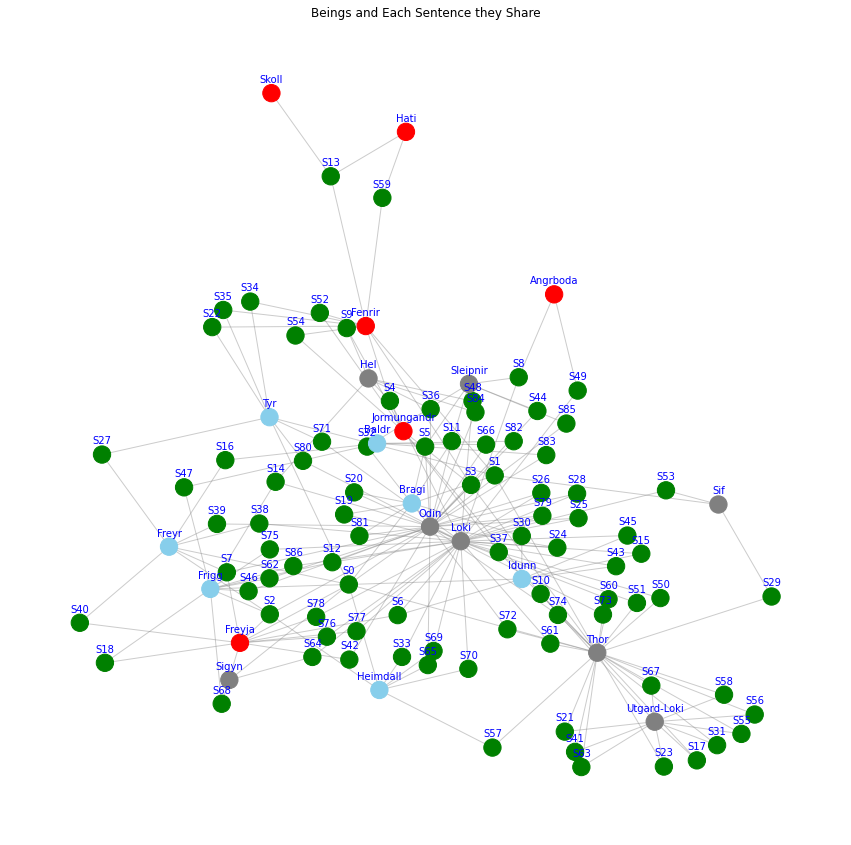

In [63]:
plt.figure(figsize=(15,15))
pos = nx.spring_layout(in_common_graph,k=0.35,iterations=80)
pos_labels = {}
keys = pos.keys()
for key in keys:
    x, y = pos[key]
    pos_labels[key] = (x, y+0.032)

nx.draw_networkx_labels(in_common_graph, pos_labels, font_color="blue", font_size=10)
nx.draw_networkx_edges(in_common_graph, pos, edge_color="gray", alpha=0.4)
nx.draw_networkx_nodes(in_common_graph, pos, node_color=[alignment_color_map[in_common_graph.nodes[node]['category']] for node in in_common_graph], node_size=300)
plt.axis("off")
plt.title("Beings and Each Sentence they Share")
plt.show()

At a glance, the nodes most populous in connections are the Gods Odin, Thor, and Loki. No sentences particularly stand out as ones with many connections. At least, they seem far less consequential than the beings in these myths, and so, the sentences will not be considered in their own graph in favor of the beings themselves.

Since this graph is bipartite, `networkx` had the ability to make a projected bipartite graph from it. The same colors were used once again, except this time, Gods had circular nodes, jotunn had triangular nodes, and monsters had square nodes.

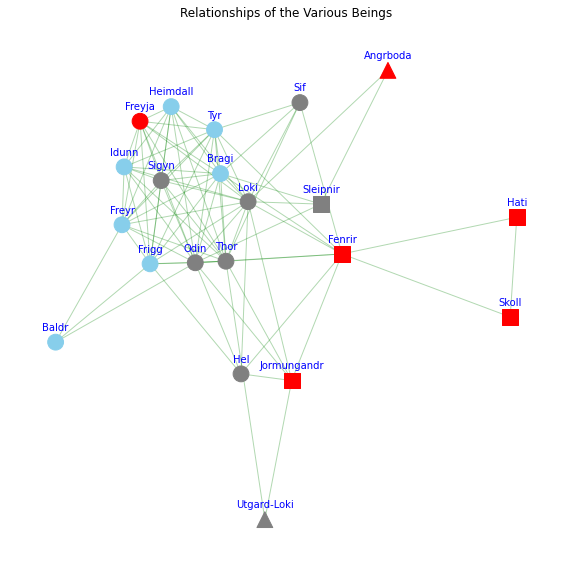

In [64]:
common_sent_nodes, common_being_nodes = bipartite.sets(in_common_graph)
common_being_graph = bipartite.projected_graph(in_common_graph, common_being_nodes)
plt.figure(figsize=(10,10))
pos = nx.spring_layout(common_being_graph,k=0.55,iterations=80)
pos_labels = {}
keys = pos.keys()
for key in keys:
    x, y = pos[key]
    pos_labels[key] = (x, y+0.035)
nx.draw_networkx_labels(common_being_graph, pos_labels, font_color="blue", font_size=10)
nx.draw_networkx_edges(common_being_graph, pos, edge_color="green", alpha=0.3)
nx.draw_networkx_nodes(common_being_graph, pos, nodelist=monsters, node_color=[alignment_color_map[common_being_graph.nodes[node]['category']] for node in monsters], node_shape="s", node_size=250)
nx.draw_networkx_nodes(common_being_graph, pos, nodelist=gods, node_color=[alignment_color_map[common_being_graph.nodes[node]['category']] for node in gods], node_shape="o", node_size=250)
nx.draw_networkx_nodes(common_being_graph, pos, nodelist=giants, node_color=[alignment_color_map[common_being_graph.nodes[node]['category']] for node in giants], node_shape="^", node_size=250)
plt.axis("off")
plt.title("Relationships of the Various Beings")
plt.show()

Working solely off of observation, it can be seen that the beings with the least number of connections are those of the Bad alignment, with two of them having no connection to any other nodes but themselves and one other Bad node - Hati, Skoll, and Fenrir. Those with the most connections of the beings are three Gods labeled as Neutral by the data analysis performed: Odin, Thor, and Loki.

This network itself also allows for a great deal of further analysis, such as below, where the degree centrality and eigenvector centrality is considered for each node. Perhaps unsurprisingly, these equations confirm what we have seen visually.

In [65]:
degrees_df = pd.DataFrame({
    "Name": alignments["name"].tolist(),
    "Centrality, Degree": list(dict(sorted(nx.degree_centrality(common_being_graph).items())).values()),
    "Centrality, Eigenvector": list(dict(sorted(nx.eigenvector_centrality(common_being_graph).items())).values())
    }
)
degrees_df

,Name,"Centrality, Degree","Centrality, Eigenvector"
0,Angrboda,0.10,0.037951
1,Baldr,0.15,0.080158
2,Bragi,0.65,0.299428
3,Fenrir,0.50,0.177577
4,Freyja,0.50,0.266006
5,Freyr,0.55,0.272771
6,Frigg,0.60,0.282211
7,Hati,0.10,0.018030
8,Heimdall,0.50,0.266006
9,Hel,0.25,0.111850


While the degree and eigenvector centrality is all well and good, with a small set of data, it might be preferred to look at the actual counts of neighbors, given below in three bar charts.

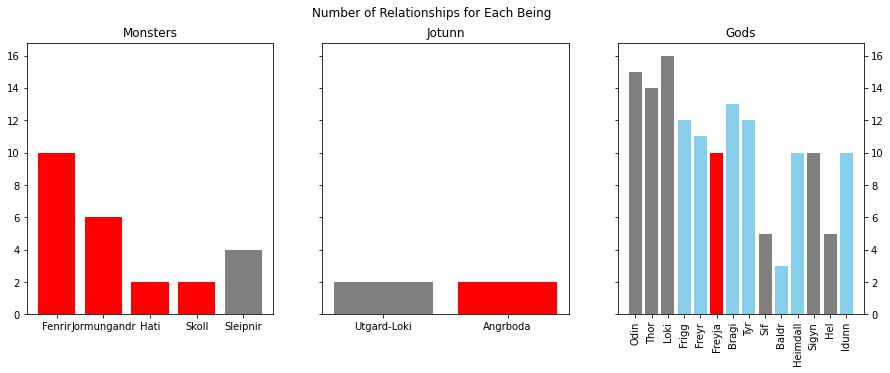

In [66]:
relationships = {}
for being in common_being_graph:
    relationships[being] = len(list(nx.all_neighbors(common_being_graph, being)))

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
plt.xticks(rotation=90)
axs[0].bar(monsters, [relationships[monster] for monster in monsters], 
           color=[alignment_color_map[common_being_graph.nodes[monster]['category']] for monster in monsters])
axs[0].set_title("Monsters")
axs[1].bar(giants, [relationships[giant] for giant in giants], 
           color=[alignment_color_map[common_being_graph.nodes[giant]['category']] for giant in giants])
axs[1].set_title("Jotunn")
axs[2].bar(gods, [relationships[god] for god in gods], 
           color=[alignment_color_map[common_being_graph.nodes[god]['category']] for god in gods])
axs[2].set_title("Gods")
plt.tick_params(labelright=True, right=True)
plt.suptitle("Number of Relationships for Each Being")
plt.show()

Of the monsters, the Fenrir has the most connections, while Hati and Skoll have the least. These monsters are all related to each other, funnily enough, so it might be expected to see similar numbers of nodes as neighbors. But that was not the case.

Next, in the jotunn, we have a low turnout for the number of relationships. This is again expected - Utgard-Loki only appeared in verses with Loki and Thor, and Angrboda only appeared in two verses total. This might have looked different if the other jotunn were involved, but the precise distinction between jotunn and Gods in the Eddas is a difficult one to make - some jotunn are born to Gods, and a not-insignificant number of Gods are born to jotunn.

On that note, the bar chart for the Gods has confirmed what our eyes saw, that Odin, Thor, and Loki have the most relationships out of all the beings, with the short-lived Baldr having the least.

Looking at this from the perspective of the category of being for provides plenty of information about those categories - monsters, jotunn, and Gods. What of the perspective of their alignment, instead?

#### Alignment by association

"Birds of a feather flock together," or so the saying goes. If it's to be believed, who you associate with may speak more for who you are than who you believe you actually are. A similar correlation had the potential to show itself in the beings of the Eddas based on whether they were Good, Neutral, or Bad..

In [67]:
relationships_df = pd.DataFrame({"Name": alignments["name"]})

for category in ["Good", "Neutral", "Bad"]:
    relationlist = []
    for each_name in relationships_df["Name"].tolist():
        being_relationlist = []
        for relation in common_being_graph.neighbors(each_name):
            if common_being_graph.nodes[relation]["category"] == category:
                being_relationlist.append(relation)
        relationlist.append(len(being_relationlist))
    relationships_df[category + " Neighbors"] = relationlist

relationships_df["Total Neighbors"] = relationships_df["Name"].apply(lambda x: len(list(common_being_graph.neighbors(x))))

Another data frame was created, this time of the relationships between the various beings. The total number of neighbors each being had on the graphs above, belonging to which alignment, was recorded. It produced the chart you see below.

In [68]:
relationships_df

,Name,Good Neighbors,Neutral Neighbors,Bad Neighbors,Total Neighbors
0,Angrboda,0,2,0,2
1,Baldr,2,1,0,3
2,Bragi,5,6,2,13
3,Fenrir,2,5,3,10
4,Freyja,6,4,0,10
5,Freyr,6,4,1,11
6,Frigg,6,5,1,12
7,Hati,0,0,2,2
8,Heimdall,5,4,1,10
9,Hel,1,2,2,5


Just barely eking out the lead for number of total of neighbors, which could also be seen as number of definite relationships, is Loki. Those who are not his neighbors - or who the data implies he has no relationship with - are a very interesting set. Namely: Hati, Skoll, Utgard-Loki, and Baldr. Hati and Skoll are the sons of Fenrir, who is Loki's son, making them Loki's grandchildren. And yet, there is nothing in the data directly linking the two. After this, we have Utgard-Loki, who has been a feature of debate among the community that has studied these myths - a question as to whether Loki and Utgard-Loki are truly separate beings or one in the same. Lastly, Baldr. Loki lead to Baldr's death, but their names do not share in a sentence, which is strange, when you think people would be accusing Loki of the murder.

Then there's Angrboda, the jotunn who mothered most of Loki's children. She has a total of two neighbors. Without looking at the graph we had seen, it is easy to assume these two are from among Loki and their children. One is indeed Loki; the other is the child Loki had mothered himself - long story.

On the other hand, when observing Odin, who came in second for the number of neighbors, his list makes far more sense for beings he shares no relationship with based off of analysis. These are Sif, his daughter-in-law; Angrboda, the jotunn who mothered most of Loki's children; Utgard-Loki, who Odin never met as far as can be told from reading; and Hati and Skoll, Fenrir's sons. This list makes far more sense.

The above gives a look at each of the beings individually, but what about when grouped by their alignments?

In [69]:
total_relationships_df = {
    "Alignment": ["Good", "Neutral", "Bad"],
    "Total Good Neighbors": [[], [], []],
    "Total Neutral Neighbors": [[], [], []],
    "Total Bad Neighbors": [[], [], []]
}

for k, v in list(common_being_graph.edges):
    als = ["Good", "Neutral", "Bad"]
    k_align = alignments.at[int(alignments[alignments["name"]==k].index[0]), "alignment, norm"]
    v_align = alignments.at[int(alignments[alignments["name"]==v].index[0]), "alignment, norm"]
    total_relationships_df["Total " + v_align + " Neighbors"][als.index(k_align)].append(v) if v not in total_relationships_df["Total " + v_align + " Neighbors"][als.index(k_align)] else None
    total_relationships_df["Total " + k_align + " Neighbors"][als.index(v_align)].append(k) if k not in total_relationships_df["Total " + k_align + " Neighbors"][als.index(v_align)] else None

for al in als:
    total_relationships_df["Total " + al + " Neighbors"] = [len(each) for each in total_relationships_df["Total " + al + " Neighbors"]]

total_relationships_df = pd.DataFrame(total_relationships_df)
total_relationships_df["Total Neighbors"] = total_relationships_df.sum(axis=1, numeric_only=True)

To do so, each edge in the earlier graph showing all of the relationships was examined; the alignment of the nodes making up that edge were taken into account and if the node was not already present within the list for a given alignment's list of neighbors of a particular alignment, it was added. The result is below.

In [70]:
total_relationships_df

,Alignment,Total Good Neighbors,Total Neutral Neighbors,Total Bad Neighbors,Total Neighbors
0,Good,7,7,2,16
1,Neutral,7,8,4,19
2,Bad,6,8,4,18


Based on the data analysis performed, the number of neighbors - or relationships - had by those of the Neutral alignment were the greatest - this is likely due to those of the Neutral alignment not particularly shying away from interacting from the Good or Bad, and being able to act as a middle ground. Those of the Good alignment appear more insular, but this would likely be even more extreme if Freyja had not been labeled Bad by the data, and the Bad alignment would have more insular relationships as well.

In [71]:
perc_relationships_df = pd.DataFrame({"Alignment": total_relationships_df["Alignment"].tolist()})
perc_relationships_df["Good Neighbors, % of Good"] = total_relationships_df["Total Good Neighbors"].apply(lambda x: x/7)
perc_relationships_df["Neutral Neighbors, % of Neutral"] = total_relationships_df["Total Neutral Neighbors"].apply(lambda x: x/8)
perc_relationships_df["Bad Neighbors, % of Bad"] = total_relationships_df["Total Bad Neighbors"].apply(lambda x: x/6)
perc_relationships_df

,Alignment,"Good Neighbors, % of Good","Neutral Neighbors, % of Neutral","Bad Neighbors, % of Bad"
0,Good,1.000000,0.875,0.333333
1,Neutral,1.000000,1.000,0.666667
2,Bad,0.857143,1.000,0.666667


This becomes more evident when each alignment's neighbors are considered as a percent of the total number of neighbors available for each alignment. Here, it can be seen seen that those of the Neutral alignment are more probably to have a relationship of some kind with someone who is Good or Neutral, whereas those who are Good are only certain to have friendships with their own alignments, and likely Neutral as well. Those of the Bad alignment, on the other hand, prefer interacting with those that are Good over those that are Bad like themselves.

In [72]:
perc_relationships_df.corr()

,"Good Neighbors, % of Good","Neutral Neighbors, % of Neutral","Bad Neighbors, % of Bad"
"Good Neighbors, % of Good",1.0,-0.5,-0.5
"Neutral Neighbors, % of Neutral",-0.5,1.0,1.0
"Bad Neighbors, % of Bad",-0.5,1.0,1.0


This corrolation is more clearly explained here - there is a direct, positive corrolation between the Neutral and Bad alignments having relationships with one another. On the other hand, those of the Good alignment shun those of any other alignment and have a negative corrolation towards having a relationship with them.

In general, this could imply those that are considered Good are the most polarizing. It could also imply the line between those that are Neutral and those that are Bad is far blurrier than previously thought. It could be both. Either way, beings - in this case, all Gods - that are Good are unlikely to interact with anyone outside of their alignment, but are certain to interact with someone from within their alignment.

## Conclusion

Evaluating the data lead to a series of conclusions about the inquiries made when approaching this undertaking. First and foremost, it was possible to assign alignments to the mythological beings selected using text and sentiment analysis on the Elder and Younger Eddas. It was also possible to compare the alignments that Marvel had given each of the characters inspired by these beings in the comic series Thor. Lastly, a correlation was identified between alignments and relationships.

## Sources

* 538. “Marvel Wikia Data.” GitHub, 538, 13 Oct. 2014, github.com/fivethirtyeight/data/blob/master/comic-characters/marvel-wikia-data.csv.
* Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.
* Sigfusson , Saemund, and Snorre Sturleson. The Elder Eddas of Saemund Sigfusson.: Transl. from the Original Old Norse Text into English by Benjamin Thorpe, and, The Younger Eddas of Snorre Sturleson. Transl. from the Original Old Norse Text into English by I.A. Blackwell. Translated by I. A. Blackwell and Benjamin Thorpe, 1906. Available [online](https://www.gutenberg.org/ebooks/14726) through [Project Gutenberg](https://www.gutenberg.org/).